In [1]:
DATA_FILE="/Users/texotqi/My/uhf-rfid/projs/urh-proj/test_success_shorter_20231209_1824_910MHz_20MSps_20MHz.complex16s"
SAMPLE_RATE=20e6
BANDWIDTH=20e6
FREQ=910e6

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def load_data(filename):
    # load data of bytes
    data = np.fromfile(filename, dtype=np.int8).reshape(-1, 2)
    data = data[:, 0] + 1j * data[:, 1]
    return data

data_loaded = load_data(DATA_FILE)
print(data_loaded.shape)
    

(69031900,)


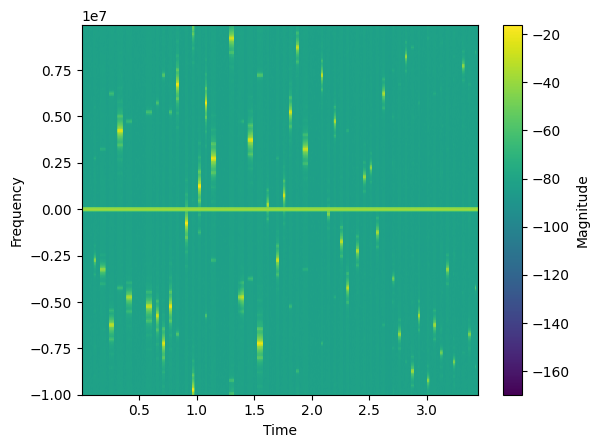

In [4]:
plt.specgram(data_loaded, Fs=SAMPLE_RATE)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Magnitude')
plt.show()



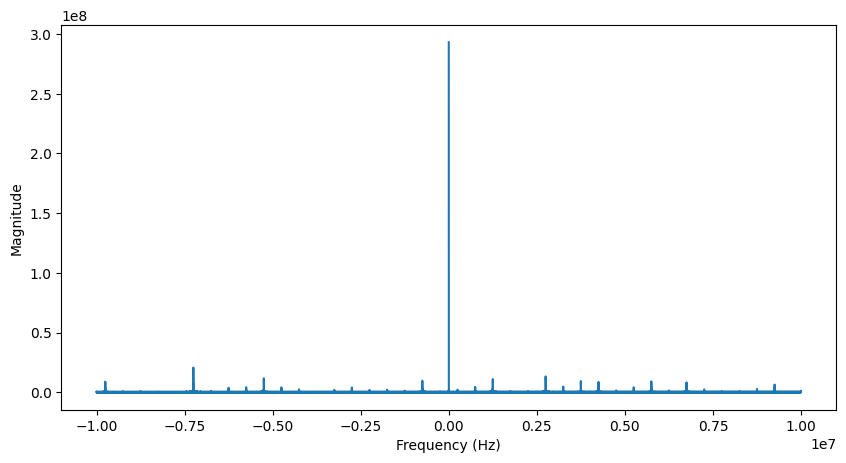

In [5]:
def plot_spectrum(data, sample_rate):
    # Compute the Fourier transform
    spectrum = np.fft.fft(data)

    # Generate the frequency values
    freq = np.fft.fftfreq(len(data), 1/sample_rate)

    # Plot the spectrum
    plt.figure(figsize=(10, 5))
    plt.plot(freq, np.abs(spectrum))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')

    # # Set the x-axis limits
    # plt.xlim(FREQ - BANDWIDTH/2, FREQ + BANDWIDTH/2)

    # # Set the x-axis ticks
    # plt.xticks(np.arange(FREQ - BANDWIDTH/2, FREQ + BANDWIDTH/2, BANDWIDTH/10))

    # Show the plot
    plt.show()

plot_spectrum(data_loaded, SAMPLE_RATE)


In [6]:
data_mag = np.abs(data_loaded)
data_mag_max = np.max(data_mag)
# data_mag_max = 1 / 0.015

if data_mag_max == 0:
    raise ValueError("data_mag_max is zero")
data_mag_norm = data_mag / data_mag_max

In [11]:
def us2len(us):
    return int(us * SAMPLE_RATE / 1e6)

# CONSTS
THRESHOLD = 0.2

MIN_DELIM_US = 3 # 12.5 - 5% = 11.875 , not standard
MAX_DELIM_US = 14 # 12.5 + 5% = 13.125

MIN_TARI_US = 6.25
MAX_TARI_US = 25

MIN_DELIM_LEN = us2len(MIN_DELIM_US)
MAX_DELIM_LEN = us2len(MAX_DELIM_US)

MIN_TARI_LEN = us2len(MIN_TARI_US)
MAX_TARI_LEN = us2len(MAX_TARI_US)


In [12]:
import numba as nb

data_sig = (data_mag_norm > THRESHOLD).astype(np.int8)

@nb.njit(parallel=False)
def find_start_positions(data_sig):
    start_positions = []
    count = 0
    current_start_position = 0
    current_length = 0

    for i in np.arange(len(data_sig)):
        if data_sig[i] == 0:
            count += 1
            if count == MIN_DELIM_LEN:
                current_start_position = i - count + 1
                current_length = 1
            elif count > MIN_DELIM_LEN:
                current_length += 1
        else:
            if current_length > 0:
                if current_length < MAX_DELIM_LEN:
                    start_positions.append(current_start_position)
            count = 0
            current_start_position = 0
            current_length = 0
    if current_length > 0:
        if current_length < MAX_DELIM_LEN:
            start_positions.append(current_start_position)

    return start_positions

start_positions = find_start_positions(data_sig)


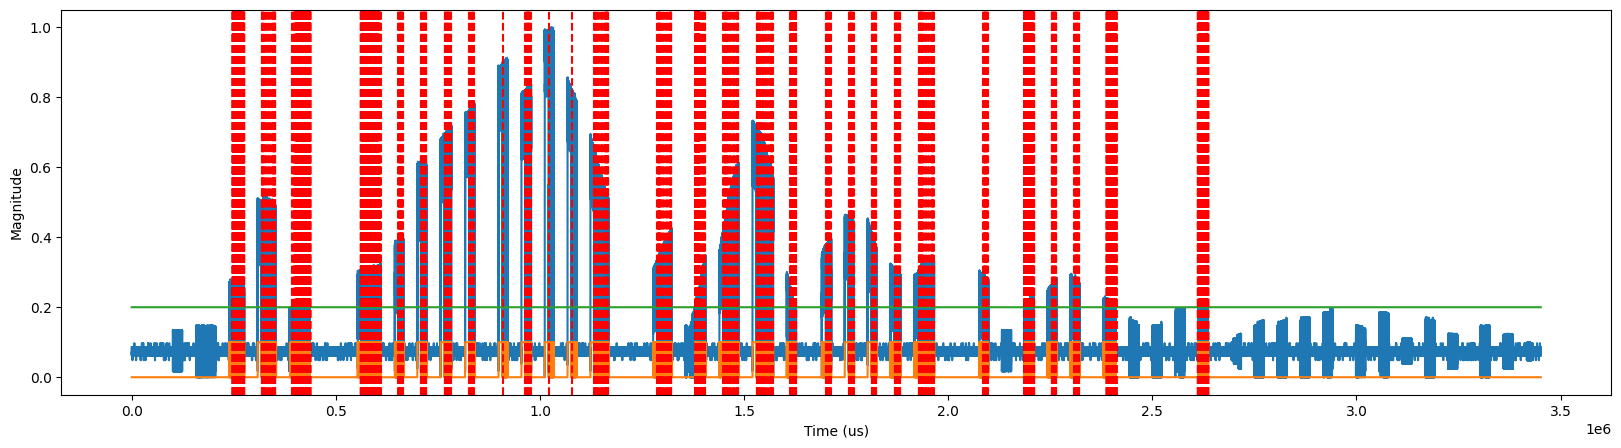

In [13]:

# Calculate the time values
time = np.arange(len(data_loaded)) / SAMPLE_RATE * 1e6

# Plot the data, wide window
plt.figure(figsize=(20, 5))
plt.plot(time, data_mag_norm)
plt.plot(time, data_sig * 0.1)

# plot threshold
plt.plot(time, np.ones(len(data_loaded)) * THRESHOLD)

for start_pos in start_positions:
    plt.axvline(x=time[start_pos], color='r', linestyle='--')


# plt.xlim(10000, 15000)


# Set the x-axis label
plt.xlabel('Time (us)')

# Set the y-axis label
plt.ylabel('Magnitude')

plt.show()



In [17]:
DEBUG = False

class DataStream:
    def __init__(self, data):
        self.data = data
        self.index = 0

    def next(self, count = 1):
        if self.index >= len(self.data):
            raise StopIteration
        value = self.data[self.index]
        self.index += count
        return value
    
    def get(self, offset = 0):
        if self.index + offset >= len(self.data):
            return None
        return self.data[self.index + offset]

    def __len__(self):
        return len(self.data) - self.index


class DecodeError(Exception):
    def __init__(self, name, message):
        super().__init__(message if name is None else f"{message} [{name}]")

class EOFError(DecodeError): pass

class InvalidLengthError(DecodeError): pass

def read_cont(iter: DataStream, min_len = 1, max_len = None, low = False, read_through = False, expect_potential_eof = False, tolerance = 8, revert_on_error = True, name = None):
    if name is None:
        if low:
            name = "L"
        else:
            name = "H"
    expect_value = int(not low)

    count = 0
    try:
        if iter.get() == None:
            if not expect_potential_eof:
                raise EOFError(name, "Unexpected EOF")
            if min_len > 0:
                raise InvalidLengthError(name, f"Value is too short: {0} < {min_len}")

        while True:
            current_value = iter.get()
            if current_value is None:
                if not expect_potential_eof:
                    raise EOFError(name, "Unexpected EOF")
                break

            if current_value != expect_value:
                try_offset = 1
                try_value = None
                while try_offset <= tolerance and (max_len is None or count + try_offset + 1 <= max_len):
                    try_value = iter.get(try_offset)
                    if try_value == expect_value:
                        break
                    try_offset += 1
                if try_value != expect_value:
                    break
                current_value = try_value
                iter.next(try_offset)
                count += try_offset

            iter.next()
            count += 1
            if not read_through and (max_len is not None and count > max_len):
                raise InvalidLengthError(name, f"Value is too long: {count} > {max_len}")

        if min_len is not None and count < min_len:
            raise InvalidLengthError(name, f"Value is too short: {count} < {min_len}")
        if max_len is not None and count > max_len:
            raise InvalidLengthError(name, f"Value is too long: {count} > {max_len}")
    except:
        if revert_on_error:
            iter.index -= count
            count = 0
            if DEBUG:
                print(f"Revert in {name}")
        raise

    return count

def read_bit(iter: DataStream, min_len = None, max_len = None, read_through = False, expect_potential_eof = False, revert_on_error = True, name = "Bit"):
    count_high = read_cont(iter, min_len=min_len * 0.5 if min_len is not None else None, max_len=max_len, low=False, read_through=read_through, revert_on_error=True, name=f"{name}.H")
    if DEBUG:
        print(f"{name}.H: {count_high / SAMPLE_RATE * 1e6}")
    try:
        count_low = read_cont(iter, max_len=max_len - count_high, low=True, read_through=read_through, expect_potential_eof=expect_potential_eof, revert_on_error=True, name=f"{name}.L")
        if DEBUG:
            print(f"{name}.L: {count_low / SAMPLE_RATE * 1e6}")
    except:
        if revert_on_error:
            iter.index -= count_high
            if DEBUG:
                print(f"Revert in {name}")
        raise
    count = count_high + count_low
    try:
        if min_len is not None and count < min_len:
            raise InvalidLengthError(name, f"Value is too short: {count} < {min_len}")
        if max_len is not None and count > max_len:
            raise InvalidLengthError(name, f"Value is too long: {count} > {max_len}")
    except:
        if revert_on_error:
            iter.index -= count
            if DEBUG:
                print(f"Revert in {name}")
        raise
    return count

def decode_frame_sync(iter: DataStream, name = "FrameSync"):
    # Delimiter
    read_cont(iter, MIN_DELIM_LEN, MAX_DELIM_LEN, low=True, name=f"{name}.Delim")

    # Data-0
    tari_size = read_bit(iter, MIN_TARI_LEN, MAX_TARI_LEN, expect_potential_eof=True, name=f"{name}.Data0")

    # RTcal
    rtcal_size = read_bit(iter, tari_size * 2.2, tari_size * 3.3, name=f"{name}.RTcal")
    
    return tari_size, rtcal_size


def decode_preamble(iter: DataStream, name = "Preamble", force_trcal = False):
    tari_size, rtcal_size = decode_frame_sync(iter, name=name)

    # TRcal
    try:
        trcal_size = read_bit(iter, rtcal_size * 1.1, rtcal_size * 3, name=f"{name}.TRcal")
    except InvalidLengthError:
        if force_trcal:
            raise
        if DEBUG:
            print(f"{name}.TRcal not found")
        trcal_size = 0
    
    return tari_size, rtcal_size, trcal_size
    

def decode_pie_symbol(iter: DataStream, tari_size, rtcal_size, trcal_size, name = "PIESym"):
    pivot =  rtcal_size / 2
    
    try:
        size = read_bit(iter, 0.7 * tari_size, 2.3 * tari_size, name=f"{name}")
    except InvalidLengthError:
        return None
    if size < pivot:
        if DEBUG:
            print(f"{name}: bit 0")
        return 0 # , size
    else:
        if DEBUG:
            print(f"{name}: bit 1")
        return 1 # , size
    
from bitarray import bitarray
import libscrc

COMMAND_DICT = {
    "QueryRep": bitarray("00"),
    "ACK": bitarray("01"),
    "Query": bitarray("1000"),
    "QueryAdjust": bitarray("1001"),
    "Select": bitarray("1010"),
    "Reserved": bitarray("1011"),
    "NAK": bitarray("11000000"),
    "Req_RN": bitarray("11000001"),
    "Read": bitarray("11000010"),
    "Write": bitarray("11000011"),
    "Kill": bitarray("11000100"),
    "Lock": bitarray("11000101"),
    "Access": bitarray("11000110"),
    "BlockWrite": bitarray("11000111"),
    "BlockErase": bitarray("11001000"),
    "BlockPermaLock": bitarray("11001001"),
    # "ISO18000-63": bitarray("11001010") - 11010001,
    "ReadBuffer": bitarray("11010010"),
    "FileOpen": bitarray("11010011"),
    "Challenge": bitarray("11010100"),
    "Authenticate": bitarray("11010101"),
    "SecureComm": bitarray("11010110"),
    "AuthComm": bitarray("11010111"),
    # "Reserved 2": bitarray("11011000"),
    # "ISO18000-63 2": bitarray("11011001"),
    # "Reserved 3": bitarray("11011010") - 11011111,
    # "Reserved custom commands": bitarray("11100000 00000000") - 11100000 11111111,
    # "Reserved propriety commands": bitarray("11100001 00000000") - 11100001 11111111,
    "Untraceable": bitarray("11100010 00000000"),
    "FileList": bitarray("11100010 00000001"),
    "KeyUpdate": bitarray("11100010 00000010"),
    "TagPrivilege": bitarray("11100010 00000011"),
    "FilePrivilege": bitarray("11100010 00000100"),
    "FileSetup": bitarray("11100010 00000101"),
    # "Reserved 4": bitarray("11100010 00000110") - 11101111 11111111,
}

def crc_bitwise(width, data, poly, init):
    assert type(data) == bitarray
    assert type(poly) == bitarray and len(poly) == width
    assert type(init) == bitarray and len(init) == width

    reg = init.copy()
    data_length = len(data)
    
    # Main CRC calculation loop
    for i in range(0, data_length):
        if data[i] ^ reg[0]:
            reg = (reg << 1) ^ poly
        else:
            reg = reg << 1

    return reg

def crc_bitwise_5_epc(data):
    return crc_bitwise(5, data, bitarray("01001"), bitarray("01001"))

def crc_bitwise_16_ccitt_false(data):
    poly = bitarray()
    poly.frombytes(b"\x10\x21")
    init = bitarray()
    init.frombytes(b"\xFF\xFF")
    return crc_bitwise(16, data, poly, init)

class CommandValidator:
    def __init__(self, length_reqs: [str], crc=None, callback=None):
        taken = set()
        self.length_reqs = []
        for length_req in length_reqs.split(","):
            if length_req == "":
                continue
            assert len(length_req) > 1
            assert length_req[0] in ['>', '<', '=']
            assert length_req[1:].isnumeric()
            if length_req[0] in taken:
                raise ValueError(f"Duplicate length check type: {length_req[0]}")
            taken.add(length_req[0])
            self.length_reqs.append((length_req[0], int(length_req[1:])))
        assert crc is None or crc in [5, 16]
        self.crc = crc
        self.callback = callback

    @staticmethod
    def check_length(symbols, length_check_type, length_value):
        if length_check_type == ">":
            return len(symbols) > length_value
        elif length_check_type == "<":
            return len(symbols) < length_value
        elif length_check_type == "=":
            return len(symbols) == length_value
        else:
            raise ValueError(f"Invalid length check type: {length_check_type}")

    def __call__(self, symbols):
        for length_check_type, length_value in self.length_reqs:
            if not self.check_length(symbols, length_check_type, length_value):
                return False

        if self.crc is not None:
            if self.crc == 5:
                data_for_crc = symbols[:-5]
                crc = crc_bitwise_5_epc(data_for_crc)
                if symbols[-5:] != crc:
                    print(f"Unmatch CRC-5: {symbols[-5:].to01()} != {crc.to01()}")
                    return False
            elif self.crc == 16:
                crc = crc_bitwise_16_ccitt_false(symbols[:-16]) ^ bitarray("1" * 16)
                if symbols[-16:] != crc:
                    print(f"Unmatch CRC-16: {symbols[-16:].to01()} != {crc.to01()}")
                    return False

        if self.callback is not None:
            if not self.callback(symbols):
                return False

        return True


COMMAND_VALIDATE_DICT = {
    "QueryRep": CommandValidator("=4"),
    "ACK": CommandValidator("=18"),
    "Query": CommandValidator("=22", crc=5),
    "QueryAdjust": CommandValidator("=9"),
    "Req_RN": CommandValidator("=40", crc=16),
    "Access": CommandValidator("=56", crc=16),
    "Read": CommandValidator("=58", crc=16),
}

def decode_command_query_rep(symbols):
    assert len(symbols) == 4
    assert symbols[0:2] == COMMAND_DICT["QueryRep"]
    session = symbols[2:4].to01()
    return f"session={session}"

def decode_command_ack(symbols):
    assert len(symbols) == 18
    assert symbols[0:2] == COMMAND_DICT["ACK"]
    return f"RN16/handle={symbols[2:18].tobytes().hex()}"

def decode_command_query(symbols):
    assert len(symbols) == 22
    assert symbols[0:4] == COMMAND_DICT["Query"]
    return f"DR={symbols[4]}, M={symbols[5:7].to01()}, TRext={symbols[7]}, Sel={symbols[8:10].to01()}, Session={symbols[10:12].to01()}, Target={symbols[12]}, Q={symbols[13:17].tobytes()[0]}, CRC5={symbols[17:22].to01()}"

def decode_command_query_adjust(symbols):
    assert len(symbols) == 9
    assert symbols[0:4] == COMMAND_DICT["QueryAdjust"]
    return f"Session={symbols[4:6].to01()}, UpDn={symbols[6:9].to01()}"

def decode_command_req_rn(symbols):
    assert len(symbols) == 40
    assert symbols[0:8] == COMMAND_DICT["Req_RN"]
    return f"RN16/handle={symbols[8:24].tobytes().hex()}, CRC16={symbols[24:40].tobytes().hex()}"

def decode_command_access(symbols):
    assert len(symbols) == 56
    assert symbols[0:8] == COMMAND_DICT["Access"]
    pass_decoded = symbols[8:24] ^ symbols[24:40]
    return f"Password={symbols[8:24].tobytes().hex()}, Password(Dec)={pass_decoded.tobytes().hex()}, handle={symbols[24:40].tobytes().hex()}, CRC16={symbols[40:56].tobytes().hex()}"

def decode_command_read(symbols):
    assert len(symbols) == 58
    assert symbols[0:8] == COMMAND_DICT["Read"]
    return f"MemBank={symbols[8:10].to01()}, WordPtr={symbols[10:18].tobytes().hex()}, WordCount={symbols[18:26].tobytes().hex()}, handle={symbols[26:42].tobytes().hex()}, CRC16={symbols[42:58].tobytes().hex()}"

COMMAND_DECODER_DICT = {
    "QueryRep": decode_command_query_rep,
    "ACK": decode_command_ack,
    "Query": decode_command_query,
    "QueryAdjust": decode_command_query_adjust,
    "Req_RN": decode_command_req_rn,
    "Access": decode_command_access,
    "Read": decode_command_read,
}

class CommandInfo:
    def __init__(self, tari_size, rtcal_size, trcal_size, command, symbols):
        self.tari_size = tari_size
        self.rtcal_size = rtcal_size
        self.trcal_size = trcal_size
        self.command = command
        self.symbols = symbols


def decode_command(data, start, end):
    iter = DataStream(data[start:end])

    try:
        tari_size, rtcal_size, trcal_size = decode_preamble(iter)
    except:
        return None
    # print(f"tari_size={tari_size}, rtcal_size={rtcal_size}, trcal_size={trcal_size}")
    # print(f"tari_us={tari_size / SAMPLE_RATE * 1e6}, rtcal_us={rtcal_size / SAMPLE_RATE * 1e6}, trcal_us={trcal_size / SAMPLE_RATE * 1e6}")

    symbols = []
    while True:
        symbol = decode_pie_symbol(iter, tari_size, rtcal_size, trcal_size)
        if symbol is None:
            break
        symbols.append(symbol)
    symbols = bitarray(symbols)

    if len(symbols) < 2:
        raise DecodeError("Command", f"Too few symbols: {len(symbols)} < 2: {symbols.to01()}")
    
    try:
        dec = next(symbols.iterdecode(COMMAND_DICT))
    except ValueError:
        raise DecodeError("Command", f"Invalid command, symbols={symbols.to01()}")

    return CommandInfo(tari_size, rtcal_size, trcal_size, dec, symbols)

for i in range(0, len(start_positions)):
    try:
        info = decode_command(data_sig, start_positions[i], start_positions[i + 1] if i + 1 < len(start_positions) else len(data_sig))
        if info is None:
            continue
        start_info = f"start={start_positions[i]}{'[P]' if info.trcal_size > 0 else '[S]'}"
        command_info= f"cmd={info.command.ljust(10, ' ')}"
        if info.command in COMMAND_VALIDATE_DICT:
            if COMMAND_VALIDATE_DICT[info.command](info.symbols):
                command_detail = COMMAND_DECODER_DICT[info.command](info.symbols)
            else:
                command_detail = f"invalid, length={'{:>3d}'.format(len(info.symbols))}, symbols={info.symbols.to01()}"
        else:
            command_detail = f"length={'{:>3d}'.format(len(info.symbols))}, symbols={info.symbols.to01()}"
        print(f"{start_info}, "
              f"{command_info}, "
              f"tari_us={'{:>5.2f}'.format(info.tari_size / SAMPLE_RATE * 1e6)}, "
              f"rtcal_us={'{:>5.2f}'.format(info.rtcal_size / SAMPLE_RATE * 1e6)}, "
              f"trcal_us={'{:>5.2f}'.format(info.trcal_size / SAMPLE_RATE * 1e6)}, "
              f"{command_detail}")
    except DecodeError as e:
        print(f"start={start_positions[i]}, error={e}")



start=6368668[P], cmd=Query     , tari_us=20.10, rtcal_us=60.10, trcal_us=66.50, DR=1, M=10, TRext=1, Sel=00, Session=00, Target=0, Q=64, CRC5=01010
start=6391764[S], cmd=QueryRep  , tari_us=20.35, rtcal_us=60.10, trcal_us= 0.00, session=00
start=6403738[S], cmd=QueryRep  , tari_us=20.15, rtcal_us=60.10, trcal_us= 0.00, session=00
start=6416727[S], cmd=QueryRep  , tari_us=20.10, rtcal_us=60.15, trcal_us= 0.00, session=00
start=6429045[S], cmd=QueryRep  , tari_us=20.15, rtcal_us=59.90, trcal_us= 0.00, session=00
start=6440911[S], cmd=QueryAdjust, tari_us=20.10, rtcal_us=59.95, trcal_us= 0.00, Session=00, UpDn=011
start=6459872[S], cmd=ACK       , tari_us=20.10, rtcal_us=60.10, trcal_us= 0.00, RN16/handle=dc68
start=6511819[S], cmd=Req_RN    , tari_us=20.15, rtcal_us=59.90, trcal_us= 0.00, RN16=dc68, CRC16=9f40
start=6586578[S], cmd=Req_RN    , tari_us=20.15, rtcal_us=59.90, trcal_us= 0.00, RN16=ca5a, CRC16=2084
start=6626406[S], cmd=Access    , tari_us=20.40, rtcal_us=59.90, trcal_us= 0